<p style="text-align:center">
    <a href="https://nbviewer.jupyter.org/github/twMr7/Python-Machine-Learning/blob/master/15-Machine_Learning_with_Scikit.ipynb">
        Open In Jupyter nbviewer
        <img style="float: center;" src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" width="120" />
    </a>
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/Python-Machine-Learning/blob/master/15-Machine_Learning_with_Scikit.ipynb)

# 15. Machine Learning with Scikit

**Scikit-learn** 提供了簡單有效率的資料分析工具，其中整合了相當多在執行機器學習任務過程所需要的套件：
+ 資料前處理： 數據正規化、類別欄位轉數值。
+ 特徵工程： 特徵選取、特徵萃取、特徵降維。
+ 學習模型： Classification/Regression, Parametric/Non-Parametric, Supervised/Unsupervised, ... 等方法。
+ 模型選取： 交叉驗證、超參數搜尋、效能度量指標。

本章節主要內容，介紹如何利用 scikit-learn 的工具來完成機器學習的任務流程。 按照一般機器學習專案的開發順序，一開始介紹準備資料時需要做的資料集切割、交叉驗證，前處理的數據正規化，再使用 pipeline 簡化工作流程，最後加入必要的度量指標。

| 工具函式庫套件      | 網址                                                                    |
|---------------------|-------------------------------------------------------------------------|
| **`pandas`**        | [pandas.pydata.org](https://pandas.pydata.org/docs/reference/index.html)|
| **`matplotlib`**    | [matplotlib.org](https://matplotlib.org/stable/contents.html)           |
| **`scikit-learn`**  | [scikit-learn.org](https://scikit-learn.org/stable/modules/classes.html)|

+ [**15.1 資料集切割與交叉驗證**](#cross-validation)
+ [**15.2 數據正規化**](#data-normalization)
+ [**15.3 將工作流程封裝成 Pipeline**](#task-pipeline)
+ [**15.4 效能度量指標**](#performance-metrics)
+ [**15.5 理解ROC曲線**](#roc-explain)
+ [**參考資料**](#references)

In [1]:
# 預載入必要模組與環境設定
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

import numpy as np
import pandas as pd

In [2]:
# 輔助圖片顯示及嵌入 notebook
from IPython.display import Image

<a id="cross-validation"></a>

## 15.1 資料集切割與交叉驗證

在之前的章節中提到過，我們希望機器學習訓練出來的模型具有泛化能力，在上線輸入真實世界的資料時仍然維持相同的預測效能。 為了在訓練過程就能模擬真實世界面臨沒見過的新資料的狀況，在開始訓練模型之前會先把資料集做切割，保留一小部分當測試集，剩下的是訓練模型用的訓練集。


### § 資料集切割

切割成兩份的大小如何分配？ 目前沒有一個固定有效的評估標準。 機器學習裡有幾種常見的的比例分配，如 **train：test = 7:3**、**8:2**、或**9:1**等等，如何決定分配的比例取決於資料集的大小。 一般來說，訓練集越多模型學得越好，但測試集太小也不能反映真實的狀況。 例如一個 600 筆的資料集，按照 9:1 的比例分配是 540:60 筆，直覺判斷可能會覺得測試集有點少，而按照 7:3 的比例分配是 420:180 筆，可能又會覺得訓練集太小。 但如果是 1000,000 筆的資料集，按照 9:1 的比例應該會覺得測試集可以再少一點，例如 20,000 筆的測試集可能就夠多了。



Scikit-learn 在 [`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) 模組裡，提供了一個可以指定比例來做 train/test 分割的工具函式。
+ [**`train_test_split()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)。 


In [3]:
# 生成 10x2 大小的 X，以及對應的 10 個 y 數列
X = np.arange(20).reshape((10, 2)) 
y = np.zeros(10)
y[6:] = 1.0

print('X =\n', X)
print('y =\n', y)

X =
 [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]]
y =
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [4]:
from sklearn.model_selection import train_test_split

# 刻意指定一個很不剛好的比例
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# 指定的比例如果沒有剛好整數，切割時還是會調整成整數
print('X_train =\n', X_train)
print('y_train =\n\n', y_train)
print('X_test =\n', X_test)
print('y_test =\n', y_test)

X_train =
 [[12 13]
 [16 17]
 [14 15]
 [ 8  9]
 [ 0  1]
 [18 19]]
y_train =

 [1. 1. 1. 0. 0. 1.]
X_test =
 [[ 2  3]
 [10 11]
 [ 4  5]
 [ 6  7]]
y_test =
 [0. 0. 0. 0.]


In [5]:
# 沒有 shuffle 的話，切割是照原本順序
train_test_split(y, test_size=0.3, shuffle=False)

[array([0., 0., 0., 0., 0., 0., 1.]), array([1., 1., 1.])]

#### ★ 測試集要有代表性 ★

測試集一定要盡可能反映模型實際使用的狀況。 不僅僅是樣本數量大小夠不夠的問題而已，要注意所選出來的測試集裡：
1. **各類別的分布狀況是否符合實際使用狀況？**
2. **所輸入的特徵數據是否符合實際使用狀況？**

例如： 生產線上的瑕疵檢測，實際狀況常常是瑕疵的資料比正常的資料少很多，所以訓練資料常常呈現極度不平衡的比例分布狀況。 如果使用大多數是瑕疵的資料來當測試集，實際上線時可能會發現 *false positive* 的誤判過高。 這非常可能就是訓練過程不符合實際狀況的測試誤導的，因為大量的瑕疵鼓勵了模型這樣的判斷可以得高分。

例如： 深度學習裡常見的手法，在訓練資料太少時，採用 *Data Augmentation* 的手法來擴充資料時常是有效的。 據說有使用 webcam 偵測室內公共場所人群的模型，在訓練集裡加入了大量網路上抓來的圖片，結果證實是有助於模型學習出更好的辨識能力的。 像這樣擴充資料的方式，在測試集裡就應該避免放進網路抓來的圖片，也應該避免室外、路上、野外的拍攝場景，應該就只使用符合實際使用的目標情境下的影像。


In [6]:
# 指定訓練集測試集的類別分布要一致
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

print('X_train =\n', X_train)
print('y_train =\n\n', y_train)
print('X_test =\n', X_test)
print('y_test =\n', y_test)

X_train =
 [[16 17]
 [ 6  7]
 [ 2  3]
 [ 4  5]
 [ 0  1]
 [18 19]
 [14 15]]
y_train =

 [1. 0. 0. 0. 0. 1. 1.]
X_test =
 [[12 13]
 [10 11]
 [ 8  9]]
y_test =
 [1. 0. 0.]


### § 交叉驗證 Cross-Validation

資料切割成訓練集跟測試集，也確認測試集符合實際狀況，那就可以直接拿訓練集來訓練模型，拿測試集來測試訓練後的模型效能了。

Wait a minute，ちょっと待ってください，**請等一下**。

機器學習模型的演算法都需要給適合的**超參數（hyperparameters）**，而且不是任何資料都適用同一組超參數。 實務上，針對一項機器學習任務的開發，我們會使用不同的超參數組合來分別訓練模型，再從測試這些模型的結果來決定最適合的超參數。 這個挑選的過程通常會由程式迭代自動反覆進行，如果使用測試集進行超參數的評估，所選的超參數仍然有可能是針對測試集過度擬合的結果，因為測試集已經洩漏了評估的結果，使得這個過程傾向於挑選讓模型過度擬合測試集的指標分數，因此所評估的效能指標已經沒辦法公正地代表泛化的程度。

什麼？ 不測試不準，測試也不準，是在哈囉！

為了解決這樣的問題，訓練模型的超參數挑選過程不使用測試集，會從訓練集裡面再保留一部份當作評估效能的驗證集（validation set）。 驗證完挑選了適當超參數後，使用這組超參數整個訓練集重新訓練一次，再跟測試集測試取得最後模型的效能指標。 所以典型的模型訓練就變成如下圖的流程。


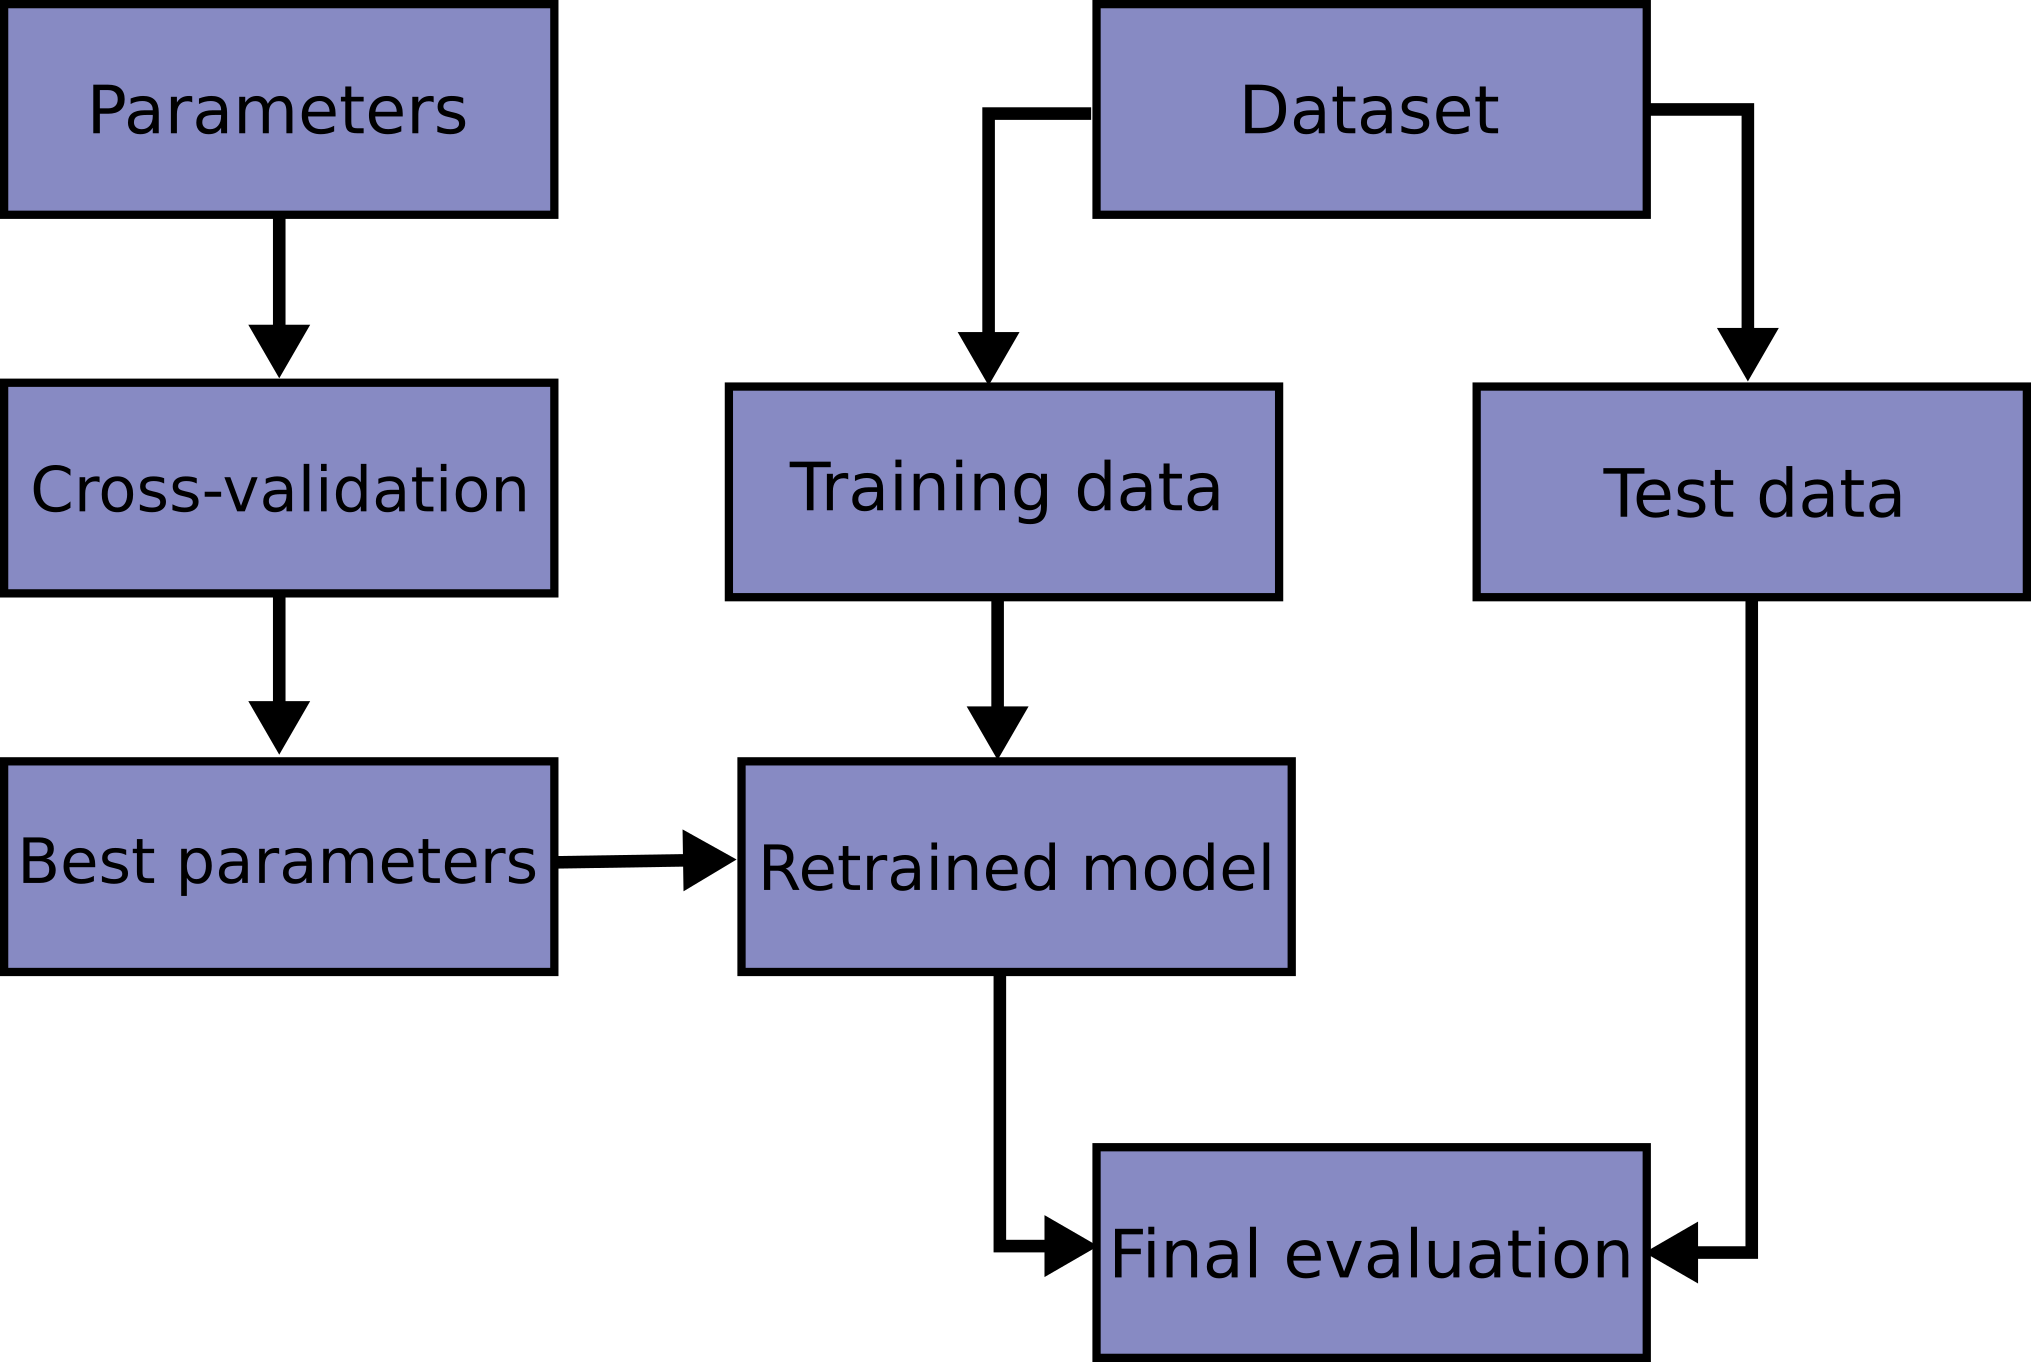

In [7]:
# 典型的模型訓練流程圖
Image(url='https://scikit-learn.org/stable/_images/grid_search_workflow.png', embed=True, width=480)

#### ★ K-fold Cross-Validation ★

時常訓練集都已經不是很夠了，還要再保留一部分作驗證集那不是訓練集又變得更小了。 簡單直覺的解決方案就是： **全部的訓練集資料都分階段輪流當訓練集和驗證集**。 這個概念就是所謂的**交叉驗證（Cross-Validation）**。 基本的做法就是把訓練集拆成 k 等份，每次都只保留其中某一份作驗證，其餘的作訓練，全部 k 個等份都同樣輪流作一次，然後把 k 次的結果作平均。 這樣就所有的資料都有訓練過也驗證過，這種交叉驗證的手法我們稱為 **k-Fold Cross-Validation**。 一般常見 5-fold 或 10-fold 交叉驗證，但跟資料集切割一樣，k 是多少取決於資料集的大小跟資料特性，並沒有一體適用的方式。

由於 k-fold 交叉驗證會花比較久的時間運算，所以如果輸入資料是像語音、影像這種大型的數據，而且是有百萬筆等級的資料集，隨機抽樣 1% 都還有個一萬筆，那就不必一定要切割成 k 等份，隨機取適當數量的驗證集作驗證即可。

有一種比較極端狀況的交叉驗證，當訓練資料很少時，可以每次只保留一筆作驗證，總共有 m 筆訓練資料的話，k-fold 就要做 m 次，這個方法叫做 **Leave One Out**。


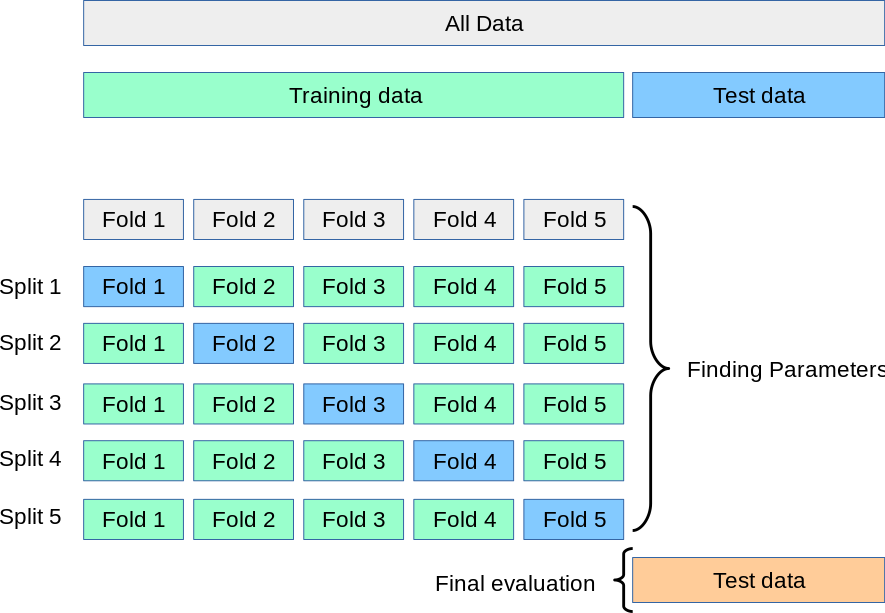

In [8]:
# k-fold 交叉驗證
Image(url='https://scikit-learn.org/stable/_images/grid_search_cross_validation.png', embed=True, width=480)


在 `sklearn.model_selection` 模組中，提供了好幾種用來交叉驗證的不同 k-fold 分割的迭代類別，這些類別都會提供一個 `split()` 的生成函數，被呼叫時會回傳 k 等份的資料序號。 常用的如下：

+ [**`KFold()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) - 一般的 k 等份分割。
+ [**`RepeatedKFold()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html) - 重覆 n 次的 k 等份分割。
+ [**`StratifiedKFold()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) - 分割方式會維持每種類別的數量比例。
+ [**`RepeatedStratifiedKFold()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedStratifiedKFold.html) - 重覆 n 次的維持類別比例分割。
+ [**`LeaveOneOut()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html) - 每次都只留一筆驗證。
+ [**`ShuffleSplit()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html) - 每次隨機排列的分割，是會重複取樣的方式。
+ [**`StratifiedShuffleSplit()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) - 每次維持類別比例的隨機排列分割。


In [9]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=3)
# 使用之前生成的 10x2 大小的 X，以及 10 個 y 的數列當訓練集
for k, (train_index, test_index) in enumerate(kfold.split(X, y)):
    print('>> Fold #', k)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    print(' - Train index:', train_index, '\n - X:', X_train, '\n - y:', y_train, '\n')
    print(' - Test index:', test_index, '\n - X:', X_test, '\n - y:', y_test, '\n')

>> Fold # 0
 - Train index: [4 5 6 7 8 9] 
 - X: [[ 8  9]
 [10 11]
 [12 13]
 [14 15]
 [16 17]
 [18 19]] 
 - y: [0. 0. 1. 1. 1. 1.] 

 - Test index: [0 1 2 3] 
 - X: [[0 1]
 [2 3]
 [4 5]
 [6 7]] 
 - y: [0. 0. 0. 0.] 

>> Fold # 1
 - Train index: [0 1 2 3 7 8 9] 
 - X: [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [14 15]
 [16 17]
 [18 19]] 
 - y: [0. 0. 0. 0. 1. 1. 1.] 

 - Test index: [4 5 6] 
 - X: [[ 8  9]
 [10 11]
 [12 13]] 
 - y: [0. 0. 1.] 

>> Fold # 2
 - Train index: [0 1 2 3 4 5 6] 
 - X: [[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]] 
 - y: [0. 0. 0. 0. 0. 0. 1.] 

 - Test index: [7 8 9] 
 - X: [[14 15]
 [16 17]
 [18 19]] 
 - y: [1. 1. 1.] 



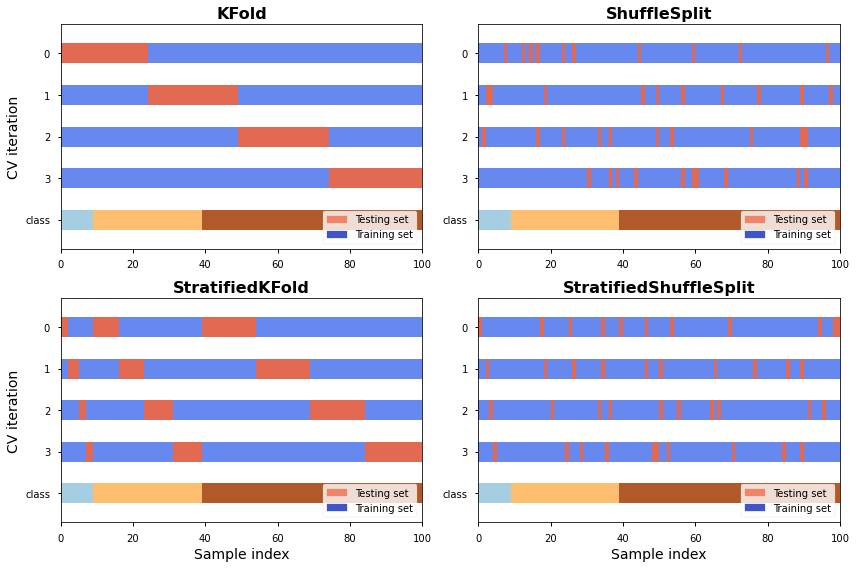

In [10]:
# 生成 100 個新的範例資料點
n_points = 100
X = np.random.randn(100, 10)

# y 包含三個分布非常不平衡的類別
percentiles_classes = [0.1, 0.3, 0.6]
y = np.hstack([[c] * int(100 * perc) for c, perc in enumerate(percentiles_classes)])

# 要顯示的不同類別
from sklearn.model_selection import (
    KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
)
cvs = [KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit]
n_splits = 4

# 用圖顯示不同 k-fold 類別的分割分配
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
x_lim = [0, n_points]
y_lim = [n_splits+1.2, -0.2]
y_ticks = np.arange(n_splits+1) + 0.5
y_ticklabels = list(range(n_splits)) + ['class']

from matplotlib.patches import Patch

for n, (cv, ax) in enumerate(zip(cvs, axs.reshape(-1))):
    cv_n = cv(n_splits=n_splits)
    for k, (idxtrain, idxtest) in enumerate(cv_n.split(X=X, y=y)):
        indices = np.zeros(X.shape[0])
        indices[idxtest] = 1.0
        ax.scatter(range(X.shape[0]), [k+0.5] * X.shape[0],
                   c=indices, marker='_', lw=20, cmap=cmap_cv,
                   vmin=-0.2, vmax=1.2)

    # Plot the data classes at the end
    ax.scatter(range(X.shape[0]), [k + 1.5] * X.shape[0],
               c=y, marker='_', lw=20, cmap=cmap_data)

    ax.set(xlim=x_lim, ylim=y_lim, yticks=y_ticks, yticklabels=y_ticklabels)
    if n in [0, 2]:
        ax.set_ylabel('CV iteration', fontsize=14)
    if n in [2, 3]:
        ax.set_xlabel('Sample index', fontsize=14)

    ax.set_title(type(cv_n).__name__, fontsize=16, fontweight='bold')

    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc='lower right')

plt.tight_layout()
plt.show()

Scikit-learn 的學習模型中，有一些是直接內建 **"cv"** 交叉驗證選項的，只需要指定如上述的這些分割類別。 如果模型沒有提供，或是自己寫的演算法需要另外做交叉驗證的流程時，在 `sklearn.model_selection` 模組中提供了 [**`cross_validate()`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) 的函式可以使用。 在下一段落中有範例示範如何使用。


<a id="data-normalization"></a>

## 15.2 數據正規化

原始數據時常會發現尺度差異大、或包含離群值（outlier）的現象，在前處理階段事先做適當的轉換，大多有助於模型的學習。 在 `sklearn.preprocessing` 模組中，提供了好幾種用來做正規化的轉換類別和函示，，類別都會提供 `fit()` 和 `transform()` 的方法來做轉換。

+ [**`StandardScaler()`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) - 標準化，將欄位數據轉換至平均為0及單位標準差。
+ [**`MinMaxScaler()`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) - 根據欄位數據的最大最小值，將數據轉換至 [0, 1] 之間。
+ [**`RobustScaler()`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) - 根據欄位數據的四分位數分布做調整，比較穩健不受離群值影響。
+ [**`Normalizer()`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) - 針對樣本空間做向量正規化的轉換。


In [11]:
from sklearn.model_selection import train_test_split

# 以下範例使用之前章節用過的 WDBC 資料集
class WdbcDataset:
    def __init__(self):
        # 載入 WDBC (Wisconsin Diagnostic Breast Cancer) 資料集
        wdbc_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
        self.df = pd.read_csv(wdbc_url, header=None)

        # 說明中描述的欄位名稱
        column_mean = [
            "radius_mean", "texture_mean", "perimeter_mean", "area_mean", "smoothness_mean",
            "compactness_mean", "concavity_mean", "concave points_mean", "symmetry_mean", "fractal_dimension_mean"
        ]
        column_se = [
            "radius_se", "texture_se", "perimeter_se", "area_se", "smoothness_se",
            "compactness_se", "concavity_se", "concave points_se", "symmetry_se", "fractal_dimension_se"
        ]
        column_worst = [
            "radius_worst", "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
            "compactness_worst", "concavity_worst", "concave points_worst", "symmetry_worst", "fractal_dimension_worst"
        ]
        column_names = ["id", "diagnosis"] + column_mean + column_se + column_worst

        # 指定欄位名稱
        self.df.columns = column_names
        # 丟掉不需要的 "id" 欄位
        self.df.drop(columns=['id'], inplace=True)
        # 將 diagnosis 欄位良性與惡性的類別轉為 0 與 1
        self.df.loc[:,'diagnosis'] = self.df.loc[:,'diagnosis'].map({'B':0, 'M':1})
    
    def get_xy(self):
        # 取所有的 X
        X = self.df.drop(columns=['diagnosis']).to_numpy()
        # 取所有的 Y
        Y = self.df.loc[:,'diagnosis'].to_numpy()
        # 資料分割 train:test = 9:1
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, stratify=Y)
        # 回傳資料副本
        return X_train.copy(), X_test.copy(), Y_train.copy(), Y_test.copy()


In [12]:
# 取得訓練集與測試集
dsWdbc = WdbcDataset()
X_train, X_test, Y_train, Y_test = dsWdbc.get_xy()

# 顯示切割後的大小
print('X: train shape = {}, test shape = {}'.format(X_train.shape, X_test.shape))
print('Y: train shape = {}, test shape = {}'.format(Y_train.shape, Y_test.shape))

# 顯示切割後的類別分布
train_labels, train_counts = np.unique(Y_train, return_counts=True)
print('Train Classes {}:{} = {}:{}'.format(train_labels[0], train_labels[1], train_counts[0], train_counts[1]))
test_labels, test_counts = np.unique(Y_test, return_counts=True)
print('Test Classes {}:{} = {}:{}'.format(test_labels[0], test_labels[1], test_counts[0], test_counts[1]))


X: train shape = (512, 30), test shape = (57, 30)
Y: train shape = (512,), test shape = (57,)
Train Classes 0:1 = 321:191
Test Classes 0:1 = 36:21


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

sklr1 = LogisticRegression(max_iter=100)
# 10-fold 交叉驗證，使用所有處理核心平行運算
scores1 = cross_validate(sklr1, X_train, Y_train, cv=10, n_jobs=-1)

# 顯示每個 fold 的 accuracy 分數
# 轉成 DataFrame 方便觀察，也方便輸出成檔案做記錄
dfscores1 = pd.DataFrame(scores1)
dfscores1

,fit_time,score_time,test_score
0,0.074999,0.001002,0.923077
1,0.056998,0.001000,0.942308
2,0.063000,0.001008,0.941176
3,0.063001,0.000999,0.980392
4,0.064998,0.000000,0.941176
5,0.073001,0.000000,0.901961
6,0.087520,0.001004,0.941176
7,0.058000,0.005001,0.980392
8,0.051519,0.001000,0.921569
9,0.036999,0.000000,0.941176


In [14]:
# 不同超參數訓練的模型比較，通常觀察平均分數
print('[Average scores]:\n', dfscores1.mean(axis=0))

[Average scores]:
 fit_time      0.063003
score_time    0.001101
test_score    0.941440
dtype: float64


### § 用 k-fold 工具自己做交叉驗證

請注意，上面使用 `cross_validate()` 函式的範例中，數據沒有事先做正規化。 但是交叉驗證的流程整個被包在函式中，正規化的轉換要如何在每個 fold `fit()` 訓練集，然後套用 `transform()` 到訓練集和驗證集？ 記得我們需要避免**數據洩漏（Data Leakage）**，所有會偷學到測試集或驗證集資訊的方法都要避免，數據轉換的方法不能拿來 `fit()` 測試集或驗證集，所以上面例子在進行 `cross_validate()` 之前，想要先對 `X_train` 做正規化有困難。

Scikit-learn 提供的解決方式是使用 **`Pipiline`** 封裝處理流程，這留在下一小節中介紹。 我們首先用 scikit-learn 提供的 k-fold 類別工具，自己試著來處理交叉驗證看看，應該會發現這些處理的步驟有點小囉嗦。

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

sklr2 = LogisticRegression(max_iter=100)
ss10fold = StratifiedShuffleSplit(n_splits=10)

scores2 = []
for k, (idx_train, idx_validate) in enumerate(ss10fold.split(X_train, Y_train)):
    # fold k 分割
    Xk_train, Xk_validate = X_train[idx_train], X_train[idx_validate]
    Yk_train, Yk_validate = Y_train[idx_train], Y_train[idx_validate]
    # 正規化
    scaler_std = StandardScaler()
    # 注意 fit() 只套用在這個 fold 的訓練分割
    scaler_std.fit(Xk_train)
    Xk_train = scaler_std.transform(Xk_train)
    Xk_validate = scaler_std.transform(Xk_validate)
    # 訓練模型
    sklr2.fit(Xk_train, Yk_train)
    # 驗證這個模型的正確率
    accuracy = sklr2.score(Xk_validate, Yk_validate)
    # 記錄這個模型的驗證正確率
    scores2.append(accuracy)
    # 結束這個 fold，顯示訊息
    print('Fold #{} accuracy = {:.3f}'.format(k, accuracy))
# 交叉驗證完成，顯示平均分數
print('\n10-fold cross-validation result: average accuracy = {:.3f}'.format(np.mean(scores2)))


Fold #0 accuracy = 0.981
Fold #1 accuracy = 1.000
Fold #2 accuracy = 0.942
Fold #3 accuracy = 0.981
Fold #4 accuracy = 0.942
Fold #5 accuracy = 0.962
Fold #6 accuracy = 0.962
Fold #7 accuracy = 1.000
Fold #8 accuracy = 0.981
Fold #9 accuracy = 0.962

10-fold cross-validation result: average accuracy = 0.971


<a id="task-pipeline"></a>

## 15.3 將工作流程封裝成 Pipeline

一個完整的機器學習專案，經常會包含多種輸入資料的清理、數據轉換，複雜一點的還會結合幾種不同的分類器模型、回歸模型在一起。 常用來簡化複雜工作流程的概念就是定義 [**`Pipeline`**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)，scikit-learn 提供的 *pipeline* 工具與套件裡的其他處理工具搭配運用，可以輔助讓複雜的工作流程比較容易且清楚的定義出來。

1. 定義在 pipeline 裡的數據轉換，本身知道如何適當`fit()`和`transform()`來避免數據洩漏。
2. scikit-learn 裡的類別工具大多有相同的介面，如`fit()`、`transform()`、`predict()` ... 等。 封裝多個物件在 pipeline 之後，所有的操作都只對 pipeline 做一次就可以。

+ [**`sklearn.pipeline.Pipeline(steps)`**](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
    - **steps**： 是工作流程的清單，照工作順序放 (*name*, *transform*) 的 tuple 清單，最後一個一定要是 estimator 類的學習模型物件。

註： Scikit-learn 文件裡 **`Transformer`** 指的是有實作 `fit()` 及 `transform()` 方法的類別； **`Estimator`** 指的是任何有實作 `transfrom()` 方法的類別。

In [16]:
# 再把剛剛不好處理的 cross-validate 用 Pipeline 做一次
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

# 定義包含正規化前處理的 pipeline
pipelr3 = Pipeline(
    steps=[
        ('zscaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=100))
    ]
)

# 10-fold 交叉驗證，使用所有處理核心平行運算
scores3 = cross_validate(pipelr3, X_train, Y_train, cv=StratifiedShuffleSplit(n_splits=10), n_jobs=-1)

# 顯示每個 fold 的 accuracy 分數
dfscores3 = pd.DataFrame(scores3)
dfscores3

,fit_time,score_time,test_score
0,0.016999,0.000000,0.980769
1,0.014000,0.000999,0.961538
2,0.015000,0.001000,0.961538
3,0.018007,0.000997,0.942308
4,0.016001,0.001004,0.980769
5,0.016998,0.001004,0.980769
6,0.016008,0.001002,1.000000
7,0.015005,0.000000,0.923077
8,0.013992,0.000000,0.980769
9,0.012997,0.001001,0.980769


In [17]:
# 觀察平均分數
print('[Average scores]:\n', dfscores3.mean(axis=0))

[Average scores]:
 fit_time      0.015501
score_time    0.000701
test_score    0.969231
dtype: float64


<a id="performance-metrics"></a>

## 15.4 效能度量指標

模型訓練後的效能度量方式，在模型設計初期的目標訂定就應決定。 不同模型有不同的適用量尺或評估指標，以下先介紹常用來評估二元分類模型的指標。 Scikit-learn 將這些工具放在 `sklearn.metrics` 模組中，常用的二元分類的度量指標如下：

+ [**`accuracy_score()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) - 正確率。
+ [**`precision_score()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html) - 精確度。
+ [**`recall_score()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) - 即**敏感度（Sensitivity）**，也可用來計算**特異性（Specificity）**。
+ [**`confusion_matrix()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) - 計算真陰性（True Negative）、假陽性（False Positive）、假陰性（False Negative）、真陽性（True Positive）。
+ [**`roc_auc_score()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) - Area Under the Receiver Operating Characteristic Curve (ROC AUC) 。


### § Confusion Matrix

| Notation  | 說明                               |
|-----------|------------------------------------|
| **+**     | *Positive*，陽性，通常是標籤 $y = 1$ |
| **−**    | *Negative*，陰性，通常是標籤 $y = 0$ |
| **TP**    | *True Positive*，真陽性個數。 預測陽性，實際也是陽性的個數。 |
| **FP**    | *False Positive*，假陽性個數。 預測陽性，實際是陰性的個數。  |
| **TN**    | *True Negative*，真陰性個數。 預測陰性，實際也是陰性的個數。 |
| **FN**    | *False Negative*，假陰性個數。 預測陰性，實際是陽性的個數。  |


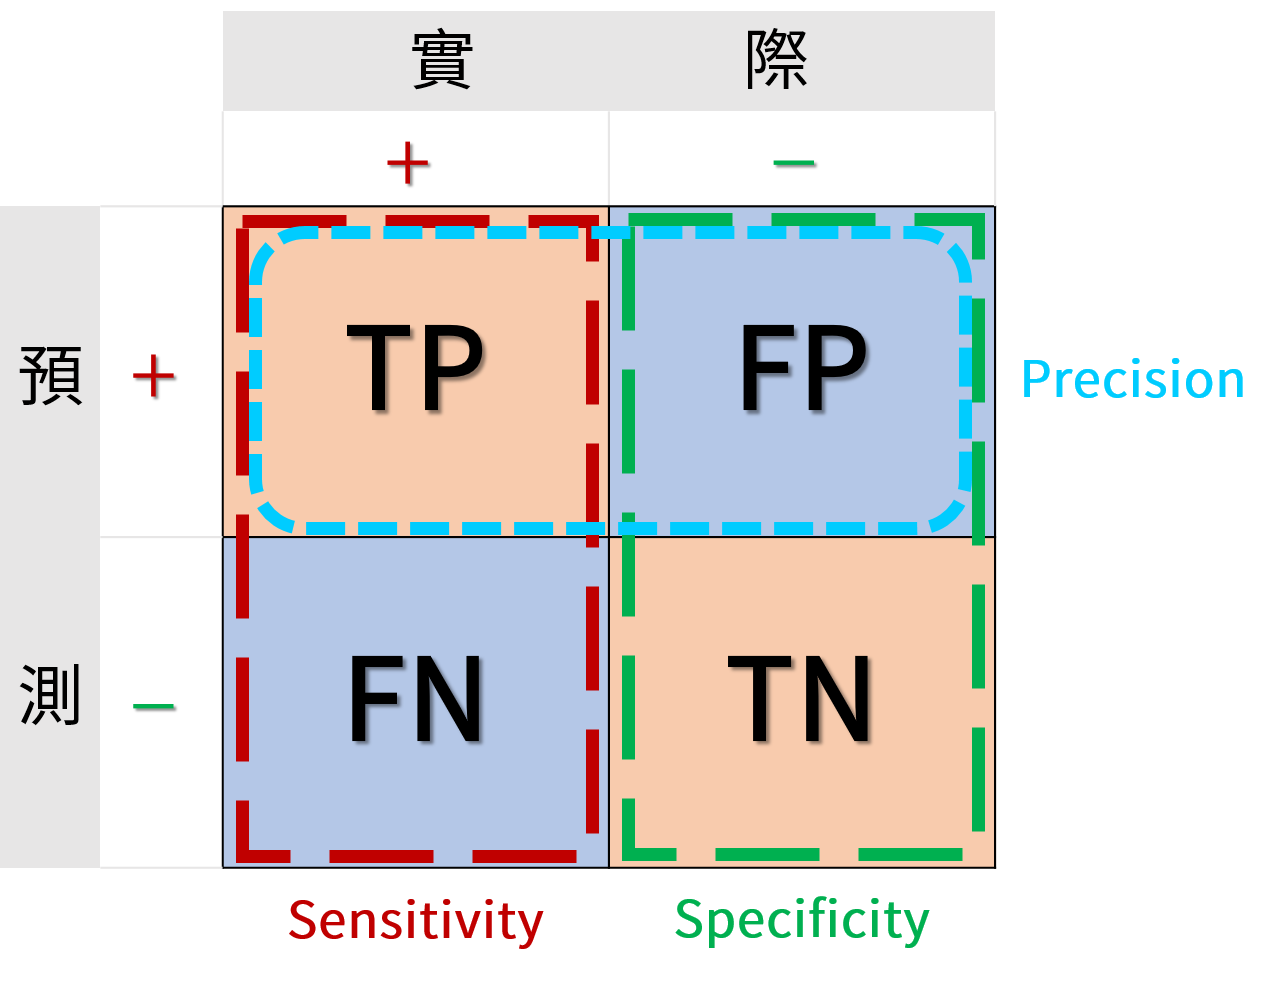

In [18]:
Image(filename='images/ConfusionMatrix.png', width=480)

### § Metrics

由不同的方向觀察 confusion matrix 表格中的個數，可對應出不同的度量指標。 基本的個數關係是：
+ 1st column，實際陽性個數 $= TP + FN$。
+ 2nd column，實際陰性個數 $= FP + TN$。
+ 1st row，預測陽性個數 $= TP + FP$。
+ 2nd row，預測陰性個數 $= TN + FN$。
+ 總群體數 $= TP + TN + FP + FN$

#### Sensitivity 敏感度

真陽性率（True Positive Rate, TPR），所有實際是陽性的，預測也是陽性的正確比例。（又稱為 **recall**）
$$
    \mathrm{Sensitivity} = \frac{TP}{TP + FN}
$$

#### Specificity 特異度

真陰性率（True Negative Rate, TPR），所有實際是陰性的，預測也是陰性的正確比例。
$$
    \mathrm{Specificity} = \frac{TN}{TN + FP}
$$

#### Precision 精確度

所有預測是陽性的，實際也是陽性的正確比例。
$$
    \mathrm{Precision} = \frac{TP}{TP + FP}
$$

#### Accuracy 正確率

對於所有群體，預測正確的比例。
$$
    \mathrm{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

#### False Positive Rate 假陽性率

假陽性率（False Positive Rate, FPR），所有實際是陰性的，錯誤預測為陽性的比例。
$$
    \mathrm{FPR} = \frac{FP}{FP + TN}
$$


### § ROC AUC

**Receiver Operating Characteristic (ROC)** 曲線是以 FPR 為 X 軸，TPR 為 Y 軸，根據二元分類模型對所有樣本預測的陽性機率，取不同機率門檻值後的累計機率分布所畫出來的曲線。

ROC 的 **Area Under Curve (AUC)** 計算曲線下的面積，使用 AUC 值做不同模型的比較會比觀察曲線的分布來得方便。

 `sklearn.metrics` 模組中也有工具可以畫 ROC 曲線：

+ [**`roc_curve()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) - 使用模型的預測機率，計算出可用來畫出 ROC 曲線的 FPR, TPR。
+ [**`plot_roc_curve()`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) - 直接透過 Matplotlib 將 ROC 曲線畫出來。

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
# 示範各 metrics 的使用
from sklearn.metrics import (
    make_scorer,
    accuracy_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    plot_roc_curve,
    confusion_matrix
)

# 與前面範例相同的 pipeline 定義
pipelr4 = Pipeline(
    steps=[
        ('zscaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=100))
    ]
)

# 交叉驗證過程可以指定多項評估指標
combo_scores = {
    'roc_auc': make_scorer(roc_auc_score),
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score, pos_label=1),
    'specificity': make_scorer(recall_score, pos_label=0)
}

# 10-fold 交叉驗證，使用所有處理核心平行運算
scores4 = cross_validate(
    pipelr4,
    X_train,
    Y_train,
    scoring=combo_scores,
    cv=StratifiedShuffleSplit(n_splits=10),
    n_jobs=-1
)

# 顯示每個 fold 的指標分數，明確指定需要的欄位
col_names = ['test_roc_auc', 'test_accuracy', 'test_sensitivity', 'test_specificity']
dfscores4 = pd.DataFrame({k:v for k,v in scores4.items() if k in col_names})
dfscores4

,test_roc_auc,test_accuracy,test_sensitivity,test_specificity
0,1.000000,1.000000,1.000000,1.000000
1,0.973684,0.980769,0.947368,1.000000
2,0.973684,0.980769,0.947368,1.000000
3,0.973684,0.980769,0.947368,1.000000
4,1.000000,1.000000,1.000000,1.000000
5,0.947368,0.961538,0.894737,1.000000
6,0.958533,0.961538,0.947368,0.969697
7,0.973684,0.980769,0.947368,1.000000
8,0.973684,0.980769,0.947368,1.000000
9,0.973684,0.980769,0.947368,1.000000


In [20]:
# 觀察平均分數
print('[Average scores]:\n', dfscores4.mean(axis=0))


[Average scores]:
 test_roc_auc        0.974801
test_accuracy       0.980769
test_sensitivity    0.952632
test_specificity    0.996970
dtype: float64


### § 最後的模型評估

記得交叉驗證目的是在找出最佳超參數，最後還是要拿所有訓練集來訓練一個最終模型與測試集做測試。


In [21]:
# 與前面範例相同的 pipeline 定義，假設超參數就是最佳
pipelr5 = Pipeline(
    steps=[
        ('zscaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=100))
    ]
)

# 直接訓練整個訓練集
pipelr5.fit(X_train, Y_train)
# 已訓練模型用來預測測試集
Y_predict = pipelr5.predict(X_test)

# confusion matrix
TN, FP, FN, TP = confusion_matrix(Y_test, Y_predict).ravel()
print('[Confusion Matrix]:\n  | TP: {} | FP: {} |\n  | FN: {} | TN: {} |\n'.format(TP, FP, FN, TN))

# sensitivity and specificity
sensitivity = recall_score(Y_test, Y_predict, pos_label=1)
specificity = recall_score(Y_test, Y_predict, pos_label=0)
print('[Testing Scores]:\n  * Sensitivity: {:.3f}\n  * Specificity: {:.3f}'.format(sensitivity, specificity))

# accuracy and ROC AUC
accuracy = accuracy_score(Y_test, Y_predict)
rocauc = roc_auc_score(Y_test, pipelr5.predict_proba(X_test)[:,1])
print('  * Accuracy: {:.3f}\n  * ROC AUC: {:.3f}'.format(accuracy, rocauc))


[Confusion Matrix]:
  | TP: 19 | FP: 0 |
  | FN: 2 | TN: 36 |

[Testing Scores]:
  * Sensitivity: 0.905
  * Specificity: 1.000
  * Accuracy: 0.965
  * ROC AUC: 0.996


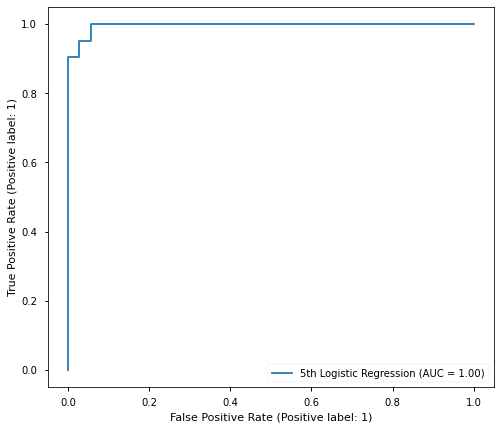

In [22]:
# 畫出 ROC 曲線
_, ax5 = plt.subplots(figsize=(8, 7))
plot_roc_curve(pipelr5, X_test, Y_test, name='5th Logistic Regression', ax=ax5)
plt.show()


<a id="roc-explain"></a>

## 15.5 理解ROC曲線

已知 ROC 的 X 軸是 FPR，Y 軸是 TPR，那是怎麼從模型預測樣本的機率中取門檻值（threshold）畫出曲線的？

首先觀察下圖中的維基百科範例，這個範例使用 Logistic Regression 模型由書的時間預測考試會pass的機率。 單一輸入變數比容易畫在機率擬合的圖上，比較方便解釋取 threshold 的過程，但以下解釋同樣適用於多變數輸入的情境。

圖上在 $y=0$ (*fail*) 與 $y=1$ (*pass*) 的線上分別有 10 個點，這些 $x$ 點是分別對應正確的 $y$ 標籤，觀察以下取不同 threshold 的變化。
+ **threshold = 0.0**： 所有的 $x$ 點都預測為 *pass*，所以 $\mathrm{FPR}=1.0$，$\mathrm{TPR}=1.0$，對應到 ROC 圖上最右上角的點。
+ **threshold = 1.0**： 所有的 $x$ 點都預測為 *fail*，所以 $\mathrm{FPR}=0.0$，$\mathrm{TPR}=0.0$，對應到 ROC 圖上最左下角的點。 從這兩個 threshold 可以觀察一個現象，在 ROC 圖上由座標 (0,0) 到 (1,1) 的對角線上的點，都是 $\mathrm{FPR} = \mathrm{TPR}$，代表是沒有鑑別力的。
+ **threshold = 0.125**： $\mathrm{TN}=4$，$\mathrm{FP}=6$，$\mathrm{FN}=0$，$\mathrm{TP}=10$，所以 $\mathrm{FPR}=0.6$，$\mathrm{TPR}=1.0$。 與 threshold=0.0 比起來，在 TPR 維持不變下 FPR 下降了，顯然取 threshold=0.125 的鑑別力比較好。 在 ROC 圖上，點 (0.6, 1.0) 比 (1.0, 1.0) 往左移，我們希望能取到一個最佳的 threshold 使得這樣的點一直往 ROC 的左上角靠，因為最左上角的點 (0.0, 1.0) 代表最好的沒有預測錯誤的狀況。
+ **threshold = 0.25**： $\mathrm{TN}=6$，$\mathrm{FP}=4$，$\mathrm{FN}=1$，$\mathrm{TP}=9$，所以 $\mathrm{FPR}=0.4$，$\mathrm{TPR}=0.9$。
+ **threshold = 0.5**： $\mathrm{TN}=8$，$\mathrm{FP}=2$，$\mathrm{FN}=2$，$\mathrm{TP}=8$，所以 $\mathrm{FPR}=0.2$，$\mathrm{TPR}=0.8$。
+ **threshold = 0.75**： $\mathrm{TN}=9$，$\mathrm{FP}=1$，$\mathrm{FN}=4$，$\mathrm{TP}=6$，所以 $\mathrm{FPR}=0.1$，$\mathrm{TPR}=0.6$。


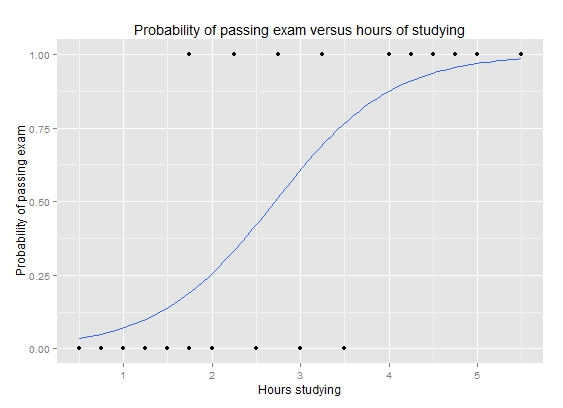

In [23]:
# 維基百科範例： Logistic Regression 模型由念書的時間預測考試會pass的機率
Image(url='https://upload.wikimedia.org/wikipedia/commons/6/6d/Exam_pass_logistic_curve.jpeg', embed=True, width=600)


### § 實際做做看

許多 sciki-learn 的模型都有一個 `predict_proba()` 的方法，在模型訓練後輸入測試樣本可以輸出擬合的預測機率。 這些測試樣本對應的機率，就如同剛剛範例中取 threshold 之後，我們手動將圖上 x 軸樣本點通過 sigmoid 函數對應到 y 軸的機率是一樣的。


In [24]:
# 取得模型預測測試集的機率 
predict_proba = pipelr5.predict_proba(X_test)
# 機率 p(y=0), p(y=1)
py0, py1 = predict_proba[:,0], predict_proba[:,1]
pd.DataFrame({'y label': Y_test, 'p(y=0)': py0, 'p(y=1)': py1})

,y label,p(y=0),p(y=1)
0,0,9.811598e-01,1.884020e-02
1,0,9.887362e-01,1.126377e-02
2,1,2.077201e-10,1.000000e+00
3,0,9.744399e-01,2.556009e-02
4,1,6.172583e-08,9.999999e-01
5,1,2.236679e-01,7.763321e-01
6,0,9.707585e-01,2.924150e-02
7,0,9.964413e-01,3.558722e-03
8,0,9.999860e-01,1.401826e-05
9,0,9.991837e-01,8.163274e-04


In [25]:
# 二元分類模型中，擬合的機率固定就是 p(y=0) + p(y=1) = 1
py0 + py1


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

In [26]:
# 取 p(y=1) 由大到小遞減排序，回傳排序後的原序號
py1_dec_index = np.argsort(py1, kind='stable')[::-1]

# 取得遞減的 p(y=1) 
py1_dec = py1[py1_dec_index]
print('p(y=1) decreasing sorted:\n', py1_dec)


p(y=1) decreasing sorted:
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99999999e-01
 9.99999938e-01 9.99999894e-01 9.99999633e-01 9.99997945e-01
 9.99997411e-01 9.99982485e-01 9.99938476e-01 9.99003864e-01
 9.98501824e-01 9.96279503e-01 9.83512385e-01 9.81046597e-01
 8.88119586e-01 7.76332096e-01 6.29468771e-01 3.72565297e-01
 2.97042844e-01 2.26159053e-01 1.05227811e-01 2.92414979e-02
 2.89625927e-02 2.55600930e-02 2.50560931e-02 2.26453131e-02
 1.88401991e-02 1.85717447e-02 1.39700575e-02 1.12637697e-02
 6.01273136e-03 5.68092234e-03 5.65302350e-03 3.85641912e-03
 3.55872235e-03 1.66227680e-03 1.52134060e-03 1.27687261e-03
 1.11087425e-03 8.16327421e-04 5.22642900e-04 4.60400905e-04
 3.79477730e-04 1.37973639e-04 9.94802246e-05 8.55792451e-05
 6.08353892e-05 5.54391511e-05 4.95101569e-05 1.48794834e-05
 1.40182578e-05 1.04978262e-05 4.94444380e-06 1.77546135e-06
 4.35553061e-07]


In [27]:
# y=1 的標籤轉成 True/False 的陣列
y_true = (Y_test == 1)

# 標籤對應 p(y=1) 的序號
y_true = y_true[py1_dec_index]
print('corresponding label y=1:\n', y_true)


corresponding label y=1:
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False]


In [28]:
# 每個 p(y=1) 都是 threshold，取累計 True Positive
tps = np.cumsum(y_true, dtype=np.float64)
print('Cumulative True Positives:\n', tps)

# 取累計 False Positive
fps = np.cumsum((1 - y_true), dtype=np.float64)
print('Cumulative False Positives:\n', fps)

Cumulative True Positives:
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 19. 20. 20. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21. 21.
 21. 21. 21.]
Cumulative False Positives:
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  1.  2.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.
 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.
 34. 35. 36.]


In [29]:
tpr = tps / tps[-1]
print('True Positive Rates:\n', tpr)

fpr = fps / fps[-1]
print('False Positive Rates:\n', fpr)

True Positive Rates:
 [0.04761905 0.0952381  0.14285714 0.19047619 0.23809524 0.28571429
 0.33333333 0.38095238 0.42857143 0.47619048 0.52380952 0.57142857
 0.61904762 0.66666667 0.71428571 0.76190476 0.80952381 0.85714286
 0.9047619  0.9047619  0.95238095 0.95238095 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
False Positive Rates:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.02777778 0.02777778 0.05555556 0.05555556 0.08333333
 0.11111111 0.13888889 0.16666667 0.19444444 0.22222222 0.25
 0.27777778 0.30555556 0.33333333 0.36111111 0.38888889 0.41

In [30]:
# 畫 ROC 曲線前補上 (0,0) 的點
tpr = np.r_[0.0, tpr]
print('True Positive Rates:\n', tpr)

fpr = np.r_[0.0, fpr]
print('False Positive Rates:\n', fpr)

True Positive Rates:
 [0.         0.04761905 0.0952381  0.14285714 0.19047619 0.23809524
 0.28571429 0.33333333 0.38095238 0.42857143 0.47619048 0.52380952
 0.57142857 0.61904762 0.66666667 0.71428571 0.76190476 0.80952381
 0.85714286 0.9047619  0.9047619  0.95238095 0.95238095 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]
False Positive Rates:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.02777778 0.02777778 0.05555556 0.05555556
 0.08333333 0.11111111 0.13888889 0.16666667 0.19444444 0.22222222
 0.25       0.27777778 0.30555556 0.3333333

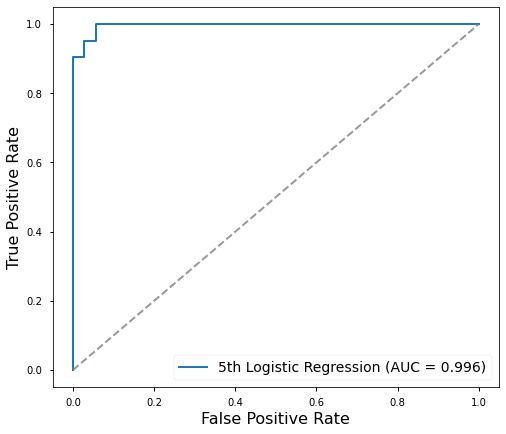

In [31]:
_, ax6 = plt.subplots(figsize=(8, 7))
# plot ROC curve
ax6.plot(fpr, tpr, label='5th Logistic Regression (AUC = {:.3f})'.format(rocauc), lw=2)

# the diagonal line
ax6.plot([0, 1], [0, 1], linestyle='--', lw=2, color='#808080', alpha=0.8)

ax6.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax6.set_xlabel('False Positive Rate', fontsize=16)
ax6.set_ylabel('True Positive Rate', fontsize=16)
ax6.legend(loc="lower right", fontsize=14)
plt.show()

<a id="references"></a>

## References:

1. Scikit-Learn, "*User Guide*", scikit-learn.org, [[link]](https://scikit-learn.org/stable/user_guide.html).
2. Wikipedia contributors, "*Sensitivity and specificity*", Wikipedia, The Free Encyclopedia, [[link]](https://en.wikipedia.org/wiki/Sensitivity_and_specificity)
3. Wikipedia contributors, "*Precision and recall*", Wikipedia, The Free Encyclopedia, [[link]](https://en.wikipedia.org/wiki/Precision_and_recall)
4. Wikipedia contributors, "*Receiver operating characteristic*", Wikipedia, The Free Encyclopedia, [[link]](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
